In [1]:
import numpy as np
import gdal
import statsmodels.api as sm 
# import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
%matplotlib inline
import seaborn as sns
#merged slope raster, accumulation area raster, and watershed raster into one three band raster.
# exported this raster into a text file from OSGeo4W command line:
# gdal2xyz input.tif -band 1 -band 2 -band 3 output.txt. This is a slow operation... 


C:\Anaconda2\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
ds = gdal.Open('S:\\JESSE\\GIS\\AngeloSagehorn\\area_slope_shed.tif')


In [3]:
band1 = ds.GetRasterBand(1)
band2 = ds.GetRasterBand(2)
band3 = ds.GetRasterBand(3)

In [4]:
# turn into 1-d arrays, and only use values > 0 (sometimes no-value data is very large negative number)
array = band1.ReadAsArray().flatten()
array1 = array[array>0]
array2 = band2.ReadAsArray().flatten()
array2 = array2[array>0]
array3 = band3.ReadAsArray().flatten()
array3 = array3[array>0]

In [5]:
elderSlope = array2[array3 == 1]
elderArea = array1[array3 == 1]
foxSlope = array2[array3 == 2]
foxArea = array1[array3 == 2]
hankSlope = array2[array3 == 3]
hankArea = array1[array3 == 3]
drySlope = array2[array3 == 4]
dryArea = array1[array3 == 4]

#Band 1 = area
#Band 2 = slope
# Band 3 = watershed

#watershed key:
#Dry = 4
#Hank = 3
#Elder = 1
#Fox = 2

In [6]:
# elderArea = elderArea + 1 #can't take log of 0
# foxArea = foxArea + 1
# hankArea = hankArea + 1 
# dryArea = dryArea + 1 


In [7]:
np.median(elderArea)

42.0

In [8]:
#GENERATE LOGARITHMIC BIN SPACING
numBins = 21

area_bins_elder = np.logspace(np.log10(min(elderArea)), np.log10(max(elderArea)), numBins)
area_bins_fox = np.logspace(np.log10(min(hankArea)), np.log10(max(hankArea)), numBins)
area_bins_hank = np.logspace(np.log10(min(hankArea)), np.log10(max(foxArea)), numBins)
area_bins_dry = np.logspace(np.log10(min(hankArea)), np.log10(max(dryArea)), numBins)


#Return the indices_elder of the bins to which each value in input array belongs.
indices_elder = np.digitize(elderArea, area_bins_elder)
indices_fox = np.digitize(foxArea, area_bins_fox)
indices_hank = np.digitize(hankArea, area_bins_hank)
indices_dry = np.digitize(dryArea, area_bins_dry)

#COMPUTE MEAN, MEDIAN AND STANDARD DEVIATION OF SLOPE IN EACH AREA BIN
bin_means_elder = [elderSlope[indices_elder == i].mean() for i in range(1, len(area_bins_elder))]
bin_medians_elder = [np.median(elderSlope[indices_elder == i]) for i in range(1, len(area_bins_elder))]
bin_stds_elder = [elderSlope[indices_elder == i].std() for i in range(1, len(area_bins_elder))]

bin_means_fox = [foxSlope[indices_fox == i].mean() for i in range(1, len(area_bins_fox))]
bin_medians_fox = [np.median(foxSlope[indices_fox == i]) for i in range(1, len(area_bins_fox))]
bin_stds_fox = [foxSlope[indices_fox == i].std() for i in range(1, len(area_bins_fox))]

bin_means_hank = [hankSlope[indices_hank == i].mean() for i in range(1, len(area_bins_hank))]
bin_medians_hank = [np.median(hankSlope[indices_hank == i]) for i in range(1, len(area_bins_hank))]
bin_stds_hank = [hankSlope[indices_hank == i].std() for i in range(1, len(area_bins_hank))]

bin_means_dry = [drySlope[indices_dry == i].mean() for i in range(1, len(area_bins_dry))]
bin_medians_dry = [np.median(drySlope[indices_dry == i]) for i in range(1, len(area_bins_dry))]
bin_stds_dry = [drySlope[indices_dry == i].std() for i in range(1, len(area_bins_dry))]



In [9]:
def kde_fit(array):
    dens = sm.nonparametric.KDEUnivariate(array)
    dens.fit()
    density = dens.density
    value = dens.support
    return density, value

elder_slope_density, elder_slope_value = kde_fit(elderSlope.astype(np.double))
elder_area_density, elder_area_value = kde_fit(elderArea.astype(np.double))
fox_slope_density, fox_slope_value = kde_fit(foxSlope.astype(np.double))
fox_area_density, fox_area_value = kde_fit(foxArea.astype(np.double))

hank_slope_density, hank_slope_value = kde_fit(hankSlope.astype(np.double))
hank_area_density, hank_area_value = kde_fit(hankArea.astype(np.double))
dry_slope_density, dry_slope_value = kde_fit(drySlope.astype(np.double))
dry_area_density, dry_area_value = kde_fit(dryArea.astype(np.double))



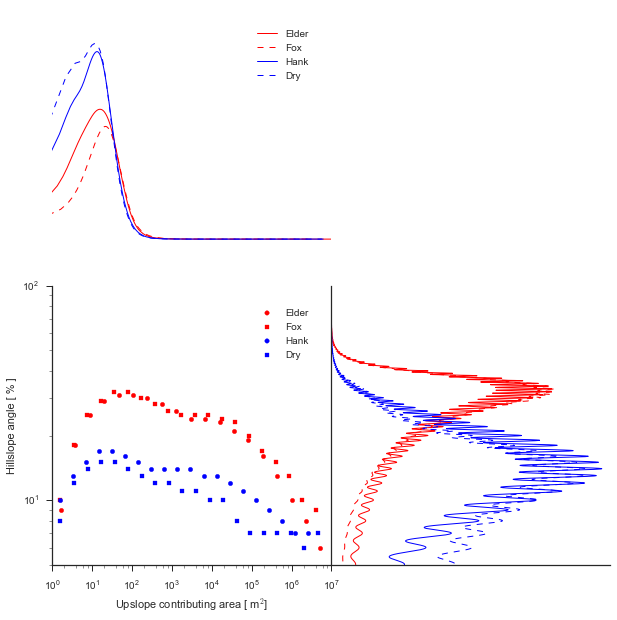

In [10]:
# Create a figure
sns.set_style("ticks")
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row')


plotError = False

ax1.plot(elder_area_value, elder_area_density, lw=1, color='r', label="Elder");
ax1.plot(fox_area_value, fox_area_density, linestyle = '--', lw=1, color='r', label="Fox");
ax1.plot(hank_area_value, hank_area_density, lw=1, color='b', label="Hank");
ax1.plot(dry_area_value, dry_area_density, linestyle = '--', lw=1, color='b', label="Dry");
ax1.legend(bbox_to_anchor=(.9, .5))

ax1.axes.get_yaxis().set_visible(False)
ax1.axes.get_xaxis().set_visible(False)
ax1.set_xscale('log')
# ax1.set_ylim([0,.03])
ax1.set_frame_on(False)

ax3.scatter(.5*(area_bins_elder[1:]+area_bins_elder[:-1]),bin_medians_elder, marker = "o", color = 'r', label="Elder")
ax3.scatter(.5*(area_bins_fox[1:]+area_bins_fox[:-1]),bin_medians_fox, marker = "s", color = 'r', label="Fox")
ax3.scatter(.5*(area_bins_hank[1:]+area_bins_hank[:-1]),bin_medians_hank, marker = "o", color = 'b', label="Hank")
ax3.scatter(.5*(area_bins_dry[1:]+area_bins_dry[:-1]),bin_medians_dry, marker = "s", color = 'b', label="Dry")

if plotError:
    ax3.errorbar(.5*(area_bins_elder[1:]+area_bins_elder[:-1]),bin_medians_elder, yerr=bin_stds_elder, fmt = None, capthick=0, ecolor = 'r')
    ax3.errorbar(.5*(area_bins_fox[1:]+area_bins_fox[:-1]),bin_medians_fox, yerr=bin_stds_fox, fmt = None, capthick=0, ecolor = 'r')
    ax3.errorbar(.5*(area_bins_hank[1:]+area_bins_hank[:-1]),bin_medians_hank, yerr=bin_stds_hank, fmt = None, capthick=0, ecolor = 'b')
    ax3.errorbar(.5*(area_bins_dry[1:]+area_bins_dry[:-1]),bin_medians_dry, yerr=bin_stds_dry, fmt = None, capthick=0, ecolor = 'b')

#ax3.fill_between(.5*(area_bins_elder[1:]+area_bins_elder[:-1]),np.subtract(bin_medians_elder, bin_stds_elder), np.add(bin_medians_elder,bin_stds_elder), color = 'r', alpha=0.3)
#ax3.fill_between(.5*(area_bins_fox[1:]+area_bins_fox[:-1]),np.subtract(bin_medians_fox, bin_stds_fox), np.add(bin_medians_fox,bin_stds_fox), color = 'k', alpha=0.3)
#ax3.fill_between(.5*(area_bins_hank[1:]+area_bins_hank[:-1]),np.subtract(bin_medians_hank, bin_stds_hank), np.add(bin_medians_hank,bin_stds_hank), color = 'b', alpha=0.3)
#ax3.fill_between(.5*(area_bins_dry[1:]+area_bins_dry[:-1]),np.subtract(bin_medians_dry, bin_stds_dry), np.add(bin_medians_dry,bin_stds_dry), color = 'y', alpha=0.3)

ax3.legend(bbox_to_anchor=(.95, .95))
ax3.set_ylabel("Hillslope angle [ % ]")
ax3.set_xlabel("Upslope contributing area [ m$^2$]")
ax3.set_ylim([5,100])
ax3.set_xlim([1,10000000])
ax3.set_yscale('log')
ax3.set_xscale('log')


ax4.plot(elder_slope_density, elder_slope_value, lw=1, color='r');
ax4.plot(fox_slope_density, fox_slope_value, linestyle = '--', lw=1, color='r');
ax4.plot(hank_slope_density, hank_slope_value, lw=1, color='b');
ax4.plot(dry_slope_density, dry_slope_value, linestyle = '--', lw=1, color='b');
ax4.set_yscale('log')
ax4.axes.get_yaxis().set_visible(False)
ax4.axes.get_xaxis().set_visible(False)

sns.despine()



fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)

ax2.axis('off')
fig.set_size_inches(10, 10)
plt.show()
# fig = fig.get_figure()
fig.savefig('logS_vs_logA_a.pdf', transparent=True, pad_inches=0)
